In [284]:
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas as pd
import os, pdb, re
import string
import stats
import keras.preprocessing.text as text
from keras.preprocessing import sequence
from keras import utils
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(linewidth=200,threshold=np.nan,formatter={'float_kind':float_formatter})
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_colwidth",200)
pd.set_option("display.max_rows",200)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#Preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/matt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [225]:
MAX_WORD_COUNT = 60
N_OUT = 5
BATCH_SIZE = 5
HIDDEN_SIZE = 32
NUM_LAYERS = 2
INIT_SCALE = 0.05

In [226]:
fx = lambda x: pd.read_csv(x,delimiter="\t",header=0)
train_df,test_df = map(fx, ["train.tsv","test.tsv"])
feat_names = train_df.columns.values
#train_df.head()

In [258]:
def clean_txt(txt):
    txt = ' \n '.join([''.join(row) for row in txt]).lower()
    txt = re.sub(r'[^\w\s]',' ',txt)
    df_clean = txt.split("\n")
    return df_clean

# Get full sentences from data set

In [244]:
def group_max(group):
    idx = np.where(group["Phrase"].apply(len)==group["Phrase"].apply(len).max())[0][0]
    return group["Phrase"].iloc[idx]
df = train_df.groupby("SentenceId").apply(group_max).values
#remove_stop = lambda sentence: [word for word in sentence if word not in stopwords.words('english')]

# The Love Song of J. Alfred Prufrock

In [267]:
df = pd.read_table("The Love Song of J. Alfred Prufrock.txt",header=None,names=["Line"],dtype={"Line":str})
txt = df["Line"].values
df_clean = clean_df(txt)

In [269]:
df_clean_yellow = list(filter(lambda row: "yellow" in row,df_clean))
df_clean_will = list(filter(lambda row: "will" in row,df_clean))
#df_clean = np.concatenate((df_clean_will,df_clean_yellow))
#df_clean = df_clean_yellow

In [270]:
class Data_obj():
    def __init__(self,batch_size,clean_data):
        self.epoch = 1
        self.i = self.k = 0
        self.batch_size = batch_size
        self.clean_data = clean_data
        
        self.Tokenizer = text.Tokenizer()
        self.Tokenizer.fit_on_texts(self.clean_data)
        self.words = self.Tokenizer.word_index.keys()
        self.encoded_text = self.Tokenizer.texts_to_sequences(self.clean_data)
        
        self.inverse_tokenizer = lambda num: list(self.Tokenizer.word_index.keys())[list(self.Tokenizer.word_index.values()).index(num)] #inverse
        self.inverse_tokenizer_sentence = lambda sentence: list(map(self.inverse_tokenizer,sentence))
        
        self.vocab_size = len(self.Tokenizer.word_index) + 1
        print("There are {0} unique words in data set.".format(self.vocab_size))
        
    def shuffle(self):
        rng.shuffle(self.encoded_text)
        
    def new_batch(self):
        return np.zeros((self.batch_size,2)).astype(np.int32)
    
    def generator(self):
        self.shuffle()
        batch = self.new_batch()
        self.total_examples_seen = 0
        while True:
            
            self.current_sentence = self.encoded_text[self.i]
            sentence_len = len(self.current_sentence)
            if sentence_len < 2:
                self.i += 1
                continue
            for j in range(sentence_len):
                context = self.current_sentence[j]

                if j == 0:
                    target = self.current_sentence[j+1]
                elif j == sentence_len - 1:
                    target = self.current_sentence[j-1]
                elif rng.uniform() < 0.5:
                    target = self.current_sentence[j-1]
                else:
                    target = self.current_sentence[j+1]

                batch[self.k,0] = context
                batch[self.k,1] = target
                if self.k == BATCH_SIZE - 1:
                    self.k = 0
                    yield batch
                    batch = self.new_batch()
                    self.total_examples_seen += self.batch_size
                else:
                    self.k += 1
            self.i+=1
            if self.i == len(self.encoded_text):
                self.epoch += 1
                self.i = 0
                self.shuffle()  #shuffle after epoch
                

In [271]:
data_obj = Data_obj(batch_size=BATCH_SIZE,clean_data=df_clean)
generate_batch = data_obj.generator()

There are 407 unique words in data set.


In [272]:
for i in range(5):
    data = next(generate_batch)
    print(data_obj.current_sentence,data_obj.inverse_tokenizer_sentence(data_obj.current_sentence))
    for i in data:
        print(i,data_obj.inverse_tokenizer_sentence(i))

[8, 146, 147, 11, 50, 82, 148, 149] ['of', 'restless', 'nights', 'in', 'one', 'night', 'cheap', 'hotels']
[366 367] ['politic', 'cautious']
[367   2] ['cautious', 'and']
[  2 367] ['and', 'cautious']
[368   2] ['meticulous', 'and']
[  8 146] ['of', 'restless']
[8, 146, 147, 11, 50, 82, 148, 149] ['of', 'restless', 'nights', 'in', 'one', 'night', 'cheap', 'hotels']
[146   8] ['restless', 'of']
[147  11] ['nights', 'in']
[11 50] ['in', 'one']
[50 11] ['one', 'in']
[82 50] ['night', 'one']
[5, 6, 320, 1, 103, 88, 4, 321] ['to', 'have', 'squeezed', 'the', 'universe', 'into', 'a', 'ball']
[148  82] ['cheap', 'night']
[149 148] ['hotels', 'cheap']
[5 6] ['to', 'have']
[  6 320] ['have', 'squeezed']
[320   1] ['squeezed', 'the']
[5, 6, 320, 1, 103, 88, 4, 321] ['to', 'have', 'squeezed', 'the', 'universe', 'into', 'a', 'ball']
[  1 320] ['the', 'squeezed']
[103  88] ['universe', 'into']
[88  4] ['into', 'a']
[ 4 88] ['a', 'into']
[321   4] ['ball', 'a']
[45, 46, 36, 2, 162, 163, 164] ['let', '

## Embedding layer - Turns positive integers (indexes) into dense vectors of fixed size”

In [273]:
vocabulary_size = data_obj.vocab_size
embedding_size = HIDDEN_SIZE
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_context = tf.placeholder(tf.int32, shape=[None, 1])
embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

#NCE Loss
nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
hidden_out = tf.matmul(embed, tf.transpose(nce_weights)) + nce_biases
soft_max = tf.nn.softmax(hidden_out)
loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_context,
                       inputs=embed,
                       num_sampled=1,
                       num_classes=vocabulary_size))
# Optimization 
learning_rate = tf.placeholder(tf.float32)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
saver = tf.train.Saver()
model_path = "/tmp/model.ckpt"

In [276]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    embeddings_before = embeddings.eval()
    data_obj = Data_obj(batch_size=BATCH_SIZE,clean_data=df_clean)
    generate_batch = data_obj.generator()
    cur_losses = []
    lr = 0.3
    while True:
        data = next(generate_batch)
        feed_dict = {train_inputs: data[:,0],train_context:data[:,[1]],learning_rate:lr}
        _, cur_loss = sess.run([optimizer, loss], feed_dict=feed_dict)
        cur_losses.append(cur_loss)
        if data_obj.total_examples_seen % 2000 == 0:
            print("{0} seen with running loss of {1:.3f}. Current epoch = {2}. Current lr = {3:.3f}".format(data_obj.total_examples_seen,np.mean(cur_losses),data_obj.epoch,lr))
            cur_losses = []
            lr /= 1.0
        if data_obj.epoch == 500:
            print("Finished.")
            break
    save_path = saver.save(sess,model_path )
    learnt_embeddings = embeddings.eval()

There are 407 unique words in data set.
0 seen with running loss of 3.411. Current epoch = 1. Current lr = 0.300
2000 seen with running loss of 4.227. Current epoch = 2. Current lr = 0.300
4000 seen with running loss of 3.327. Current epoch = 4. Current lr = 0.300
6000 seen with running loss of 3.438. Current epoch = 6. Current lr = 0.300
8000 seen with running loss of 2.844. Current epoch = 8. Current lr = 0.300
10000 seen with running loss of 2.689. Current epoch = 10. Current lr = 0.300
12000 seen with running loss of 2.686. Current epoch = 12. Current lr = 0.300
14000 seen with running loss of 2.297. Current epoch = 14. Current lr = 0.300
16000 seen with running loss of 2.202. Current epoch = 16. Current lr = 0.300
18000 seen with running loss of 1.943. Current epoch = 17. Current lr = 0.300
20000 seen with running loss of 1.811. Current epoch = 19. Current lr = 0.300
22000 seen with running loss of 1.660. Current epoch = 21. Current lr = 0.300
24000 seen with running loss of 1.593

In [286]:
with tf.Session() as sess:
    saver.restore(sess,model_path)
    top_n_words = 3
    for word_no in range(1,vocabulary_size)[:20]:
        word = data_obj.inverse_tokenizer(word_no)
        feed_dict={train_inputs:np.array([word_no])}
        word_embed, word_pred = sess.run([embed,soft_max],feed_dict)
        word_pred = word_pred.squeeze()
        top_n_args = word_pred.argsort()[-top_n_words:]
        print("\n")
        print(word,word_no)
        #print(word_pred)
        print(data_obj.inverse_tokenizer_sentence(top_n_args))

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


the 1
['yellow', 'window', 'known']


and 2
['murder', 'time', 'i']


i 3
['am', 'should', 'have']


a 4
['like', 'from', 'in']


to 5
['its', 'have', 'wonder']


have 6
['known', 'i', 'it']


that 7
['makes', 'will', 'rubs']


of 8
['insidious', 'my', 'restless']


it 9
['after', 'have', 'at']


all 10
['after', 'them', 'at']


in 11
['nights', 'the', 'but']


time 12
['to', 'is', 'be']


my 13
['necktie', 'hair', 'of']


is 14
['not', 'that', 'it']


will 15
['that', 'there', 'be']


you 16
['tell', 'that', 'of']


should 17
['how', 'say', 'i']


for 18
['i', 'the', 'time']


after 19
['it', 'i', 'all']


upon 20
['back', 'in', 'its']


In [287]:
pd.DataFrame(df_clean)

,0
0,let us go then you and i
1,when the evening is spread out against the sky
2,like a patient etherized upon a table
3,let us go through certain half deserted streets
4,the muttering retreats
5,of restless nights in one night cheap hotels
6,and sawdust restaurants with oyster shells
7,streets that follow like a tedious argument
8,of insidious intent
9,to lead you to an overwhelming question


In [294]:
n_words_display = 40
reduced_embeddings = TSNE(n_components=2).fit_transform(learnt_embeddings)[:n_words_display]

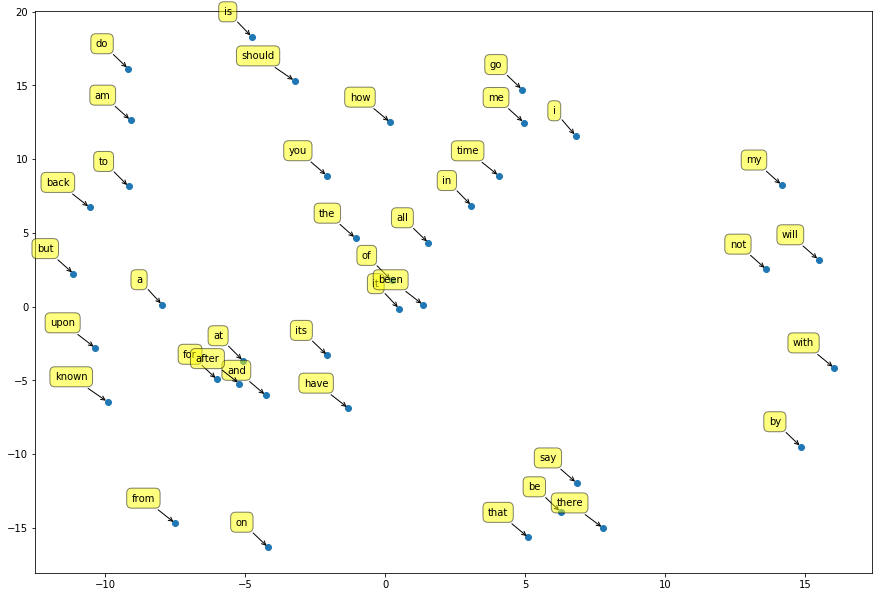

In [295]:
labels = [data_obj.inverse_tokenizer(word_no) for word_no in range(1,vocabulary_size)][:n_words_display]
plt.figure(figsize=(15,10))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    reduced_embeddings[1:, 0], reduced_embeddings[1:, 1], marker='o',
    cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(labels, reduced_embeddings[1:, 0], reduced_embeddings[1:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()